In [1]:
import sympy as sp
from sympy import *
import scipy.optimize as optimize
import numpy as np
from matplotlib import pyplot as plt
from casadi import *
from sympy import diff as smdiff
import sys
from collections import OrderedDict
import pandas as pd

## Demand and Production

In [2]:
def D1(p1, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    return κ1*p1**(-ε1)

def D2(p2, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    return κ2*p2**(-ε2)

def y(l1, l2, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    return l1**α + l2**α

def y1(l1, l2, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    return l1**α

def y2(l1, l2, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    return l2**α

def π(p1, p2, l1, l2, params, tax_functions):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    τ1, τ2 = tax_functions
    tax_rate = τ1(p1, p2, l1, l2, params) + τ2(p1, p2, l1, l2, params)
    q1 = D1(p1, params)
    q2 = D2(p2, params)
    pre_tax_profits = (p1 * q1 + p2 * q2) - (w1 * l1 + w2 * l2)
    return (1 - tax_rate) * pre_tax_profits


In [42]:
n_t1_gridpoints = 51

param_dict = OrderedDict(
    t1=0,
    t2=0.2,
    ε1=6,
    ε2=6,
    κ1=10,
    κ2=1,
    w1=1,
    w2=1,
    α=0.5,
    ρ=3,
    c=0.528475
)
params = list(param_dict.values())
t1_set = np.linspace(0, 0.4, n_t1_gridpoints)


## Separate Accounting Benchmark


In [43]:
def π_sa(q1_1, q1_2, q2_1, q2_2, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    
    l1 = (q1_1+q1_2)**(1/α)
    l2 = (q2_1+q2_2)**(1/α)
    p1 = (κ1/(q1_1+q2_1))**(1/ε1)
    p2 = (κ2/(q1_2+q2_2))**(1/ε2)
    
    pre_tax_profits1 = p1*q1_1+p2*q1_2-l1*w1
    pre_tax_profits2 = p1*q2_1+p2*q2_2-l2*w2
    
    return (1-t1) * pre_tax_profits1 + (1-t2)*pre_tax_profits2

def max_π_sa(params, x0_vals):
    
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    
    q1_1 = SX.sym("q1_1")
    q1_2 = SX.sym("q1_2")
    q2_1 = SX.sym("q2_1")
    q2_2 = SX.sym("q2_2")

    x = vertcat(q1_1, q1_2, q2_1, q2_2)

    obj = -π_sa(q1_1, q1_2, q2_1, q2_2, params)
    
    x0 = DM(x0_vals)

    nlp = {
        "x": x,
        "f": obj,
    }
    
    print_opt_diagnostics = False
    if print_opt_diagnostics:
        ipopt_print_level = 3
    else:
        ipopt_print_level = 0

    solver = nlpsol("solver", "ipopt", nlp, {
                    "ipopt.print_level": ipopt_print_level, "ipopt.tol": 1e-10, 'print_time': 0})
    solution = solver(
        x0=x0,
        lbg=-1e-9,
        ubg=1e-9,
        lbx=0,
        ubx=1e9
    )
    # print(params[:2])
    # print(solution)

    q1_1, q1_2, q2_1, q2_2 = np.array(solution["x"]).squeeze()
    
    l1 = (q1_1+q1_2)**(1/α)
    l2 = (q2_1+q2_2)**(1/α)
    p1 = (κ1/(q1_1+q2_1))**(1/ε1)
    p2 = (κ2/(q1_2+q2_2))**(1/ε2)
    
    return [p1, p2, l1, l2]

In [44]:
output_df_sa = pd.DataFrame(np.nan, index=range(n_t1_gridpoints), columns=["p1", "p2", "l1", "l2"])
initial_x0 = [1.07729, 1.22436, 0.219299, 0.21929]


for i in range(n_t1_gridpoints):
    params[list(param_dict).index("t1")] = t1_set[i]
    if i == 0:
        x0 = initial_x0
    else:
        x0 = output_df_sa.loc[i - 1, :]
    sol = max_π_sa(params, x0)
    output_df_sa.loc[i, :] = sol


price_ratios_sa = output_df_sa.loc[:, "p1"] / output_df_sa.loc[:, "p2"]
labor_ratios_sa = output_df_sa.loc[:, "l1"] / output_df_sa.loc[:, "l2"]
quant_ratios_as = D1(output_df_sa.loc[:, "p1"],params)/D2(output_df_sa.loc[:,"p2"],params)


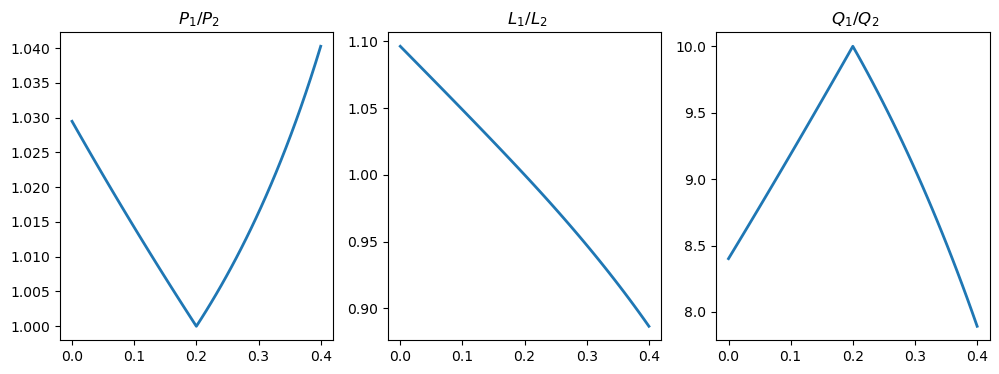

In [45]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].plot(t1_set, price_ratios_sa, linewidth=2)
ax[0].set(title=' $P_1/P_2$')
#ax[0].set_ylim([0.85,1.15])

ax[1].plot(t1_set, labor_ratios_sa, linewidth=2)
ax[1].set(title=' $L_1/L_2$')
#ax[1].set_ylim([0.85,1.15])

ax[2].plot(t1_set, quant_ratios_as, linewidth=2)
ax[2].set(title=' $Q_1/Q_2$')
#ax[2].set_ylim([0.85,1.15])

plt.savefig("fig_sa.eps")

plt.show()

## Naive Firm Benchmark


In [46]:
def π_naive(p1, p2, l1, l2, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    
    τ1 = t1/2
    τ2 = t2/2
    
    return (1-t1) * pre_tax_profits1 + (1-t2)*pre_tax_profits2

def max_π_naive(params, x0_vals):
    
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    
    q1_1 = SX.sym("q1_1")
    q1_2 = SX.sym("q1_2")
    q2_1 = SX.sym("q2_1")
    q2_2 = SX.sym("q2_2")

    x = vertcat(q1_1, q1_2, q2_1, q2_2)

    obj = -π_sa(q1_1, q1_2, q2_1, q2_2, params)
    
    x0 = DM(x0_vals)

    nlp = {
        "x": x,
        "f": obj,
    }
    
    print_opt_diagnostics = False
    if print_opt_diagnostics:
        ipopt_print_level = 3
    else:
        ipopt_print_level = 0

    solver = nlpsol("solver", "ipopt", nlp, {
                    "ipopt.print_level": ipopt_print_level, "ipopt.tol": 1e-10, 'print_time': 0})
    solution = solver(
        x0=x0,
        lbg=-1e-9,
        ubg=1e-9,
        lbx=0,
        ubx=1e9
    )
    # print(params[:2])
    # print(solution)

    q1_1, q1_2, q2_1, q2_2 = np.array(solution["x"]).squeeze()
    
    l1 = (q1_1+q1_2)**(1/α)
    l2 = (q2_1+q2_2)**(1/α)
    p1 = (κ1/(q1_1+q2_1))**(1/ε1)
    p2 = (κ2/(q1_2+q2_2))**(1/ε2)
    
    return [p1, p2, l1, l2]

In [47]:
output_df_naive = pd.DataFrame(np.nan, index=range(n_t1_gridpoints), columns=["p1", "p2", "l1", "l2"])
initial_x0 = [1.07729, 1.22436, 0.219299, 0.21929]


for i in range(n_t1_gridpoints):
    params[list(param_dict).index("t1")] = t1_set[i]
    if i == 0:
        x0 = initial_x0
    else:
        x0 = output_df_naive.loc[i - 1, :]
    sol = max_π_naive(params, x0)
    output_df_naive.loc[i, :] = sol


price_ratios_naive = output_df_naive.loc[:, "p1"] / output_df_naive.loc[:, "p2"]
labor_ratios_naive = output_df_naive.loc[:, "l1"] / output_df_naive.loc[:, "l2"]


### Setting up the optimization

In [48]:
def max_π_casadi(params, x0_vals, tax_functions):
    
    p1 = SX.sym("p1")
    p2 = SX.sym("p2")
    l1 = SX.sym("l1")
    l2 = SX.sym("l2")
    
    # q_from_1_to_1 = SX.sym("q_from_1_to_1")
    # q_from_1_to_2 = SX.sym("q_from_1_to_2")
    # q_from_2_to_1 = SX.sym("q_from_2_to_1")
    # q_from_2_to_2 = SX.sym("q_from_2_to_2")

    # What'd be really nice is to make this a matrix
    # q = SX.sym("q", 2, 2)
    # and then the row sums are production and the column sums are consumption
    # If we made prices and labor vectors too we could just write the constraints as
    # sum2(q) - D(p, params)
    # sum1(q) - y(l, params)
    # I had done some of this in Nregions Nathan Fork May15; might return to it

    x = vertcat(p1, p2, l1, l2)
    # x = vertcat(p1, p2, l1, l2, q_from_1_to_1, q_from_1_to_2, q_from_2_to_1, q_from_2_to_2)
    obj = -π(p1, p2, l1, l2, params, tax_functions)
    constraint = (D1(p1, params) + D2(p2, params)) - y(l1, l2, params) # left hand side minus right hand side
    # constraint = vertcat(
    #     (D1(p1, params)) - (q_from_1_to_1 + q_from_2_to_1),
    #     (D2(p2, params)) - (q_from_1_to_2 + q_from_2_to_2),
    #     (q_from_1_to_1 + q_from_1_to_2) - y1(l1, l2, params),
    #     (q_from_2_to_1 + q_from_2_to_2) - y2(l1, l2, params)
    # )
    x0 = DM(x0_vals)

    nlp = {
        "x": x,
        "f": obj,
        "g": constraint,
    }

    print_opt_diagnostics = False
    if print_opt_diagnostics:
        ipopt_print_level = 3
    else:
        ipopt_print_level = 0

    solver = nlpsol("solver", "ipopt", nlp, {
                    "ipopt.print_level": ipopt_print_level, "ipopt.tol": 1e-10, 'print_time': 0})
    solution = solver(
        x0=x0,
        lbg=-1e-9,
        ubg=1e-9,
        lbx=0,
        ubx=1e9
    )
    # print(params[:2])
    # print(solution)

    return np.array(solution["x"]).squeeze()


def do_opt(approach, params, x0_vals, tax_functions):
    if approach == "casadi":
        return max_π_casadi(params, x0_vals, tax_functions)
    # elif approach == "scipy":
        # return optimize.minimize(π_to_minimize, x0_vals, args=(params), method='Nelder-Mead', tol=1e-10).x
    else:
        raise ValueError("approach must be 'casadi' or 'scipy'")


## Sales Factor

In [49]:
def τ1_sfa(p1, p2, l1, l2, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    q1 = D1(p1, params)
    q2 = D2(p2, params)
    return p1*q1/(p1*q1+p2*q2)*t1


def τ2_sfa(p1, p2, l1, l2, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    q1 = D1(p1, params)
    q2 = D2(p2, params)
    return p2*q2/(p1*q1+p2*q2)*t2

In [50]:
output_df_sfa = pd.DataFrame(np.nan, index=range(n_t1_gridpoints), columns=["p1", "p2", "l1", "l2"])
initial_x0 = [1.07729, 1.22436, 0.219299, 0.21929]


for i in range(n_t1_gridpoints):
    params[list(param_dict).index("t1")] = t1_set[i]
    if i == 0:
        x0 = initial_x0
    else:
        x0 = output_df_sfa.loc[i - 1, :]
    sol = do_opt("casadi", params, x0, [τ1_sfa, τ2_sfa])
    output_df_sfa.loc[i, :] = sol


price_ratios_sfa = output_df_sfa.loc[:, "p1"] / output_df_sfa.loc[:, "p2"]
labor_ratios_sfa = output_df_sfa.loc[:, "l1"] / output_df_sfa.loc[:, "l2"]
quant_ratios_sfa = D1(output_df_sfa.loc[:, "p1"],params)/D2(output_df_sfa.loc[:,"p2"],params)



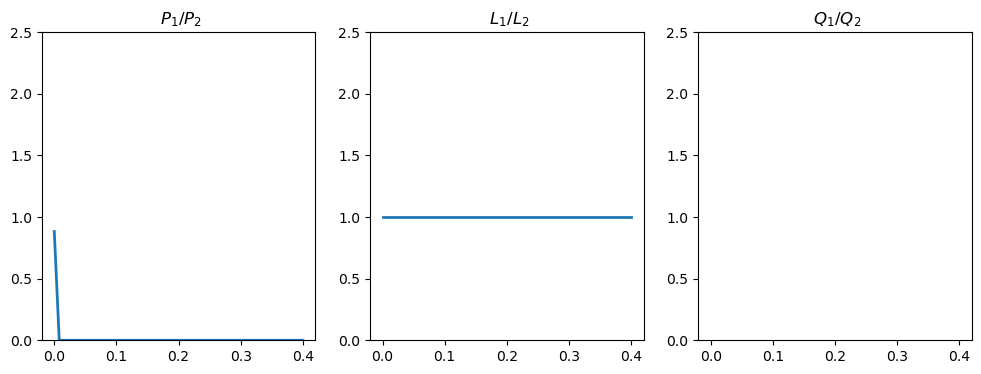

In [51]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].plot(t1_set, price_ratios_sfa, linewidth=2)
ax[0].set(title=' $P_1/P_2$')
ax[0].set_ylim([0,2.5])

ax[1].plot(t1_set, labor_ratios_sfa, linewidth=2)
ax[1].set(title=' $L_1/L_2$')
ax[1].set_ylim([0,2.5])

ax[2].plot(t1_set, quant_ratios_sfa, linewidth=2)
ax[2].set(title=' $Q_1/Q_2$')
ax[2].set_ylim([0,2.5])


plt.savefig("fig_sfa.eps")

plt.show()

## Payroll Factor (fixed wage)

In [13]:
def τ1_payroll(p1, p2, l1, l2, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    return w1*l1/(w1*l1+w2*l2)*t1


def τ2_payroll(p1, p2, l1, l2, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    return w2*l2/(w1*l1+w2*l2)*t2


In [14]:
output_df_payroll = pd.DataFrame(np.nan, index=range(n_t1_gridpoints), columns=["p1", "p2", "l1", "l2"])
initial_x0 = [1.13658, 1.13658, 0.28192, 0.157437]


for i in range(n_t1_gridpoints):
    params[list(param_dict).index("t1")] = t1_set[i]
    if i == 0:
        x0 = initial_x0
    else:
        x0 = output_df_payroll.loc[i - 1, :]
    sol = do_opt("casadi", params, x0, [τ1_payroll, τ2_payroll])
    output_df_payroll.loc[i, :] = sol


price_ratios_payroll = output_df_payroll.loc[:, "p1"] / output_df_payroll.loc[:, "p2"]
labor_ratios_payroll = output_df_payroll.loc[:, "l1"] / output_df_payroll.loc[:, "l2"]
quant_ratios_payroll = D1(output_df_payroll.loc[:, "p1"],params)/D2(output_df_payroll.loc[:,"p2"],params)



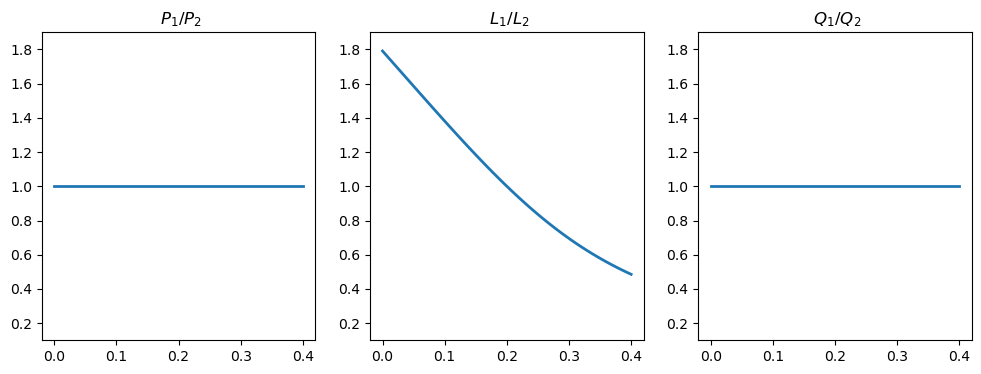

In [15]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].plot(t1_set, price_ratios_payroll, linewidth=2)
ax[0].set(title=' $P_1/P_2$')
ax[0].set_ylim([0.1,1.9])

ax[1].plot(t1_set, labor_ratios_payroll , linewidth=2)
ax[1].set(title=' $L_1/L_2$')
ax[1].set_ylim([0.1,1.9])

ax[2].plot(t1_set, quant_ratios_payroll, linewidth=2)
ax[2].set(title=' $Q_1/Q_2$')
ax[2].set_ylim([0.1,1.9])

plt.savefig("fig_payroll.eps")

plt.show()

## 50/50 Payroll and Sales

In [16]:
def τ1_split(p1, p2, l1, l2, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    q1 = D1(p1, params)
    q2 = D2(p2, params)
    return 0.5*(w1*l1/(w1*l1+w2*l2)+p1*q1/(p1*q1+p2*q2))*t1


def τ2_split(p1, p2, l1, l2, params):
    t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c = params
    q1 = D1(p1, params)
    q2 = D2(p2, params)
    return 0.5*(w2*l2/(w1*l1+w2*l2)+p2*q2/(p1*q1+p2*q2))*t2


In [17]:
output_df_split = pd.DataFrame(np.nan, index=range(n_t1_gridpoints), columns=["p1", "p2", "l1", "l2"])
initial_x0 = [1.13658, 1.13658, 0.28192, 0.157437]


for i in range(n_t1_gridpoints):
    params[list(param_dict).index("t1")] = t1_set[i]
    if i == 0:
        x0 = initial_x0
    else:
        x0 = output_df_split.loc[i - 1, :]
    sol = do_opt("casadi", params, x0, [τ1_split, τ2_split])
    output_df_split.loc[i, :] = sol


price_ratios_split = output_df_split.loc[:, "p1"] / output_df_split.loc[:, "p2"]
labor_ratios_split = output_df_split.loc[:, "l1"] / output_df_split.loc[:, "l2"]
quant_ratios_split = D1(output_df_split.loc[:, "p1"],params)/D2(output_df_split.loc[:,"p2"],params)



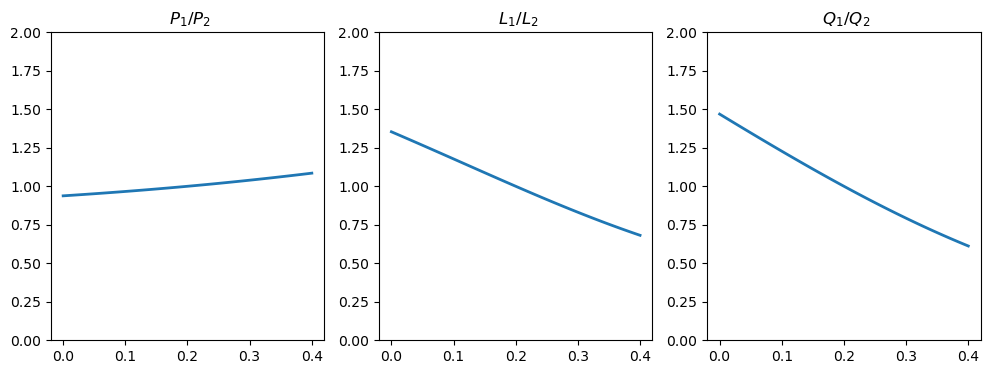

In [18]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].plot(t1_set, price_ratios_split, linewidth=2)
ax[0].set(title=' $P_1/P_2$')
ax[0].set_ylim([0,2])

ax[1].plot(t1_set, labor_ratios_split , linewidth=2)
ax[1].set(title=' $L_1/L_2$')
ax[1].set_ylim([0,2])

ax[2].plot(t1_set, quant_ratios_split, linewidth=2)
ax[2].set(title=' $Q_1/Q_2$')
ax[2].set_ylim([0,2])

plt.savefig("fig_split.eps")

plt.show()

## Payroll (monopsony)

In [19]:
def π_monopsony(p1, p2, l1, l2, params, tax_functions):
    t1, t2, ε1, ε2, κ1, κ2, _1, _2, α, ρ, c = params
    q1 = D1(p1, params)
    q2 = D2(p2, params)
    
    w1 = (l1/c)**(1/ρ) 
    w2 = (l2/c)**(1/ρ)
    
    params = t1, t2, ε1, ε2, κ1, κ2, w1, w2, α, ρ, c
    
    τ1, τ2 = tax_functions
    
    tax_rate = τ1(p1, p2, l1, l2, params) + τ2(p1, p2, l1, l2, params)
    
    pre_tax_profits = (p1 * q1 + p2 * q2) - (w1 * l1 + w2 * l2)
    return (1 - tax_rate) * pre_tax_profits

def max_π_monopsony(params, x0_vals, tax_functions):
    
    p1 = SX.sym("p1")
    p2 = SX.sym("p2")
    l1 = SX.sym("l1")
    l2 = SX.sym("l2")
    
    # q_from_1_to_1 = SX.sym("q_from_1_to_1")
    # q_from_1_to_2 = SX.sym("q_from_1_to_2")
    # q_from_2_to_1 = SX.sym("q_from_2_to_1")
    # q_from_2_to_2 = SX.sym("q_from_2_to_2")

    # What'd be really nice is to make this a matrix
    # q = SX.sym("q", 2, 2)
    # and then the row sums are production and the column sums are consumption
    # If we made prices and labor vectors too we could just write the constraints as
    # sum2(q) - D(p, params)
    # sum1(q) - y(l, params)
    # I had done some of this in Nregions Nathan Fork May15; might return to it

    x = vertcat(p1, p2, l1, l2)
    # x = vertcat(p1, p2, l1, l2, q_from_1_to_1, q_from_1_to_2, q_from_2_to_1, q_from_2_to_2)
    obj = -π_monopsony(p1, p2, l1, l2, params, tax_functions)
    constraint = (D1(p1, params) + D2(p2, params)) - y(l1, l2, params) # left hand side minus right hand side
        
    # constraint = vertcat(
    #     (D1(p1, params)) - (q_from_1_to_1 + q_from_2_to_1),
    #     (D2(p2, params)) - (q_from_1_to_2 + q_from_2_to_2),
    #     (q_from_1_to_1 + q_from_1_to_2) - y1(l1, l2, params),
    #     (q_from_2_to_1 + q_from_2_to_2) - y2(l1, l2, params)
    # )
    x0 = DM(x0_vals)

    nlp = {
        "x": x,
        "f": obj,
        "g": constraint,
    }

    print_opt_diagnostics = False
    if print_opt_diagnostics:
        ipopt_print_level = 3
    else:
        ipopt_print_level = 0

    solver = nlpsol("solver", "ipopt", nlp, {
                    "ipopt.print_level": ipopt_print_level, "ipopt.tol": 1e-10, 'print_time': 0})
    solution = solver(
        x0=x0,
        lbg=-1e-9,
        ubg=1e-9,
        lbx=0,
        ubx=1e9
    )
    # print(params[:2])
    # print(solution)

    return np.array(solution["x"]).squeeze()

In [20]:
output_df_monopsony = pd.DataFrame(np.nan, index=range(n_t1_gridpoints), columns=["p1", "p2", "l1", "l2"])
initial_x0 = [1.13658, 1.13658, 0.28192, 0.157437]


for i in range(n_t1_gridpoints):
    params[list(param_dict).index("t1")] = t1_set[i]
    if i == 0:
        x0 = initial_x0
    else:
        x0 = output_df_monopsony.loc[i - 1, :]
    sol = max_π_monopsony(params, x0, [τ1_payroll, τ2_payroll])
    output_df_monopsony.loc[i, :] = sol


price_ratios_monopsony = output_df_monopsony.loc[:, "p1"] / output_df_monopsony.loc[:, "p2"]
labor_ratios_monopsony = output_df_monopsony.loc[:, "l1"] / output_df_monopsony.loc[:, "l2"]
wage_ratios_monopsony = ((output_df_monopsony.loc[:, "l1"]/param_dict['c'])**(1/param_dict['ρ']))/((output_df_monopsony.loc[:, "l2"]/param_dict['c'])**(1/param_dict['ρ']))
quant_ratios_monopsony = D1(output_df_monopsony.loc[:, "p1"],params)/D2(output_df_monopsony.loc[:,"p2"],params)


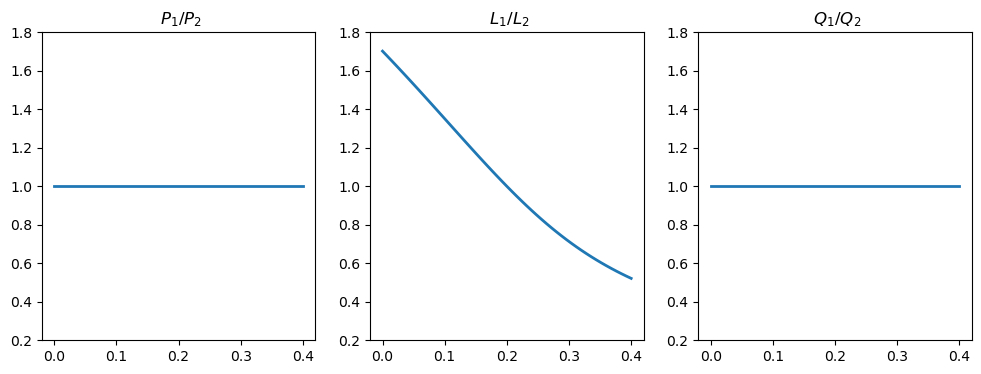

In [21]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].plot(t1_set, price_ratios_monopsony, linewidth=2)
ax[0].set(title=' $P_1/P_2$')
ax[0].set_ylim([0.2,1.8])

ax[1].plot(t1_set, labor_ratios_monopsony , linewidth=2)
ax[1].set(title=' $L_1/L_2$')
ax[1].set_ylim([0.2,1.8])

ax[2].plot(t1_set, quant_ratios_monopsony , linewidth=2)
ax[2].set(title=' $Q_1/Q_2$')
ax[2].set_ylim([0.2,1.8])

plt.savefig("fig_monopsony.eps")

plt.show()

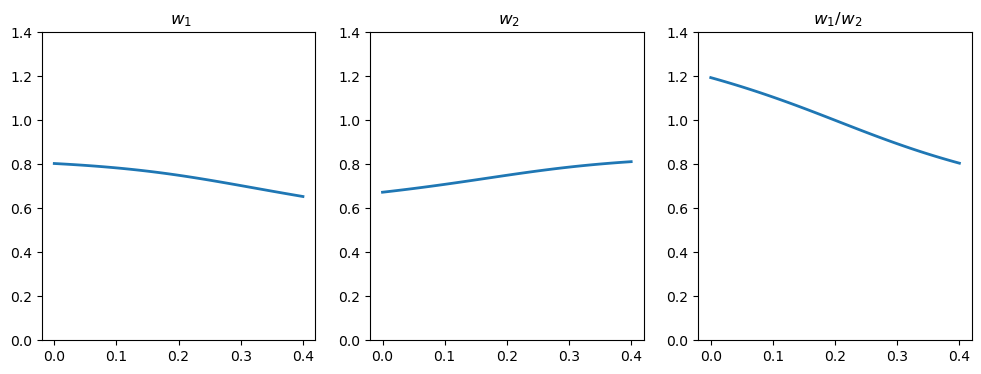

In [22]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].plot(t1_set, ((output_df_monopsony.loc[:, "l1"]/param_dict['c'])**(1/param_dict['ρ'])), linewidth=2)
ax[0].set(title=' $w_1$')
ax[0].set_ylim([0,1.4])

ax[1].plot(t1_set, ((output_df_monopsony.loc[:, "l2"]/param_dict['c'])**(1/param_dict['ρ'])), linewidth=2)
ax[1].set(title=' $w_2$')
ax[1].set_ylim([0,1.4])

ax[2].plot(t1_set, wage_ratios_monopsony , linewidth=2)
ax[2].set(title=' $w_1/w_2$')
ax[2].set_ylim([0,1.4])

plt.savefig("fig_monopsony_wage.eps")

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


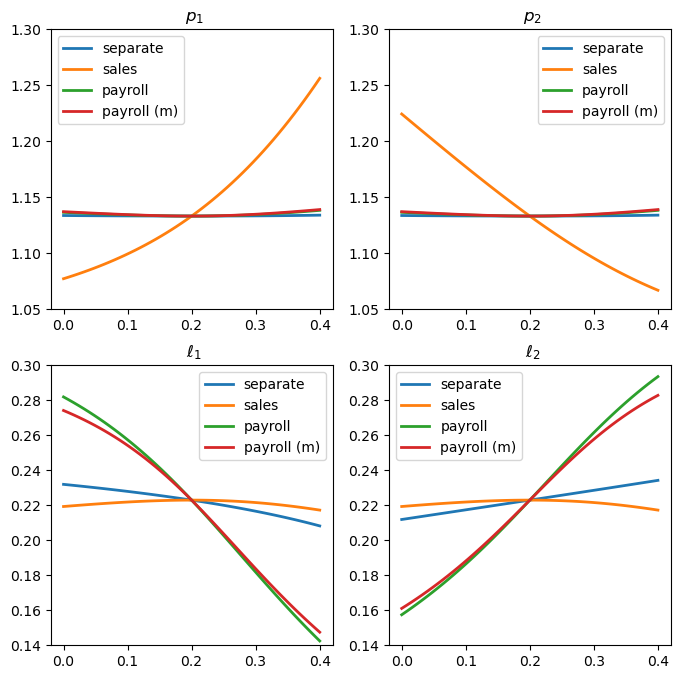

In [23]:
# Putting it all together

fig, ax = plt.subplots(2,2, figsize=(8, 8))

ax[0,0].plot(t1_set, output_df_sa.loc[:, "p1"], linewidth=2, label='separate')
ax[0,0].plot(t1_set, output_df_sfa.loc[:, "p1"], linewidth=2, label='sales')
ax[0,0].plot(t1_set, output_df_payroll.loc[:, "p1"], linewidth=2, label='payroll')
ax[0,0].plot(t1_set, output_df_monopsony.loc[:, "p1"], linewidth=2, label='payroll (m)')
ax[0,0].set(title=' $p_1$')
ax[0,0].set_ylim([1.05,1.3])
ax[0,0].legend()

ax[0,1].plot(t1_set, output_df_sa.loc[:, "p2"], linewidth=2, label='separate')
ax[0,1].plot(t1_set, output_df_sfa.loc[:, "p2"], linewidth=2, label='sales')
ax[0,1].plot(t1_set, output_df_payroll.loc[:, "p2"], linewidth=2, label='payroll')
ax[0,1].plot(t1_set, output_df_monopsony.loc[:, "p2"], linewidth=2, label='payroll (m)')
ax[0,1].set(title=' $p_2$')
ax[0,1].set_ylim([1.05,1.3])
ax[0,1].legend()

ax[1,0].plot(t1_set, output_df_sa.loc[:, "l1"], linewidth=2, label='separate')
ax[1,0].plot(t1_set, output_df_sfa.loc[:, "l1"], linewidth=2, label='sales')
ax[1,0].plot(t1_set, output_df_payroll.loc[:, "l1"], linewidth=2, label='payroll')
ax[1,0].plot(t1_set, output_df_monopsony.loc[:, "l1"], linewidth=2, label='payroll (m)')
ax[1,0].set(title=' $\ell_1$')
ax[1,0].set_ylim([0.14,0.3])
ax[1,0].legend()

ax[1,1].plot(t1_set, output_df_sa.loc[:, "l2"], linewidth=2, label='separate')
ax[1,1].plot(t1_set, output_df_sfa.loc[:, "l2"], linewidth=2, label='sales')
ax[1,1].plot(t1_set, output_df_payroll.loc[:, "l2"], linewidth=2, label='payroll')
ax[1,1].plot(t1_set, output_df_monopsony.loc[:, "l2"], linewidth=2, label='payroll (m)')
ax[1,1].set(title=' $\ell_2$')
ax[1,1].set_ylim([0.14,0.3])
ax[1,1].legend()

plt.savefig("fig_all.eps")


plt.show()